# Load Files

In [3]:
import re
import pandas as pd
import os
import seaborn as sns
import numpy as np
import warnings
import math
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [4]:
house_train = pd.read_csv('Datasets/train_Wenchang.csv')
house_test = pd.read_csv('Datasets/test_Wenchang.csv')

In [5]:
house_train.shape

(1460, 74)

In [6]:
house_test.shape

(1459, 73)

# Pre Processing

In [7]:
# Combining both house_train and house_test to clean data
house_train # 80 columns
house_test # 79 columns. need SalePrice placeholder
house_test['SalePrice'] = np.nan

# house_test starts on index row 1460 
house_full = pd.concat([house_train, house_test], axis = 0)

# Feature Engineering


### Bath Capacity

In [8]:
# Total Number of bathrooms
house_full['TotBath'] = house_full.FullBath + .5*house_full.HalfBath

# Replace zeros with median
house_full.TotBath.replace(0, house_full.TotBath.median(), inplace=True)

# Replace zero bedrooms with median bedroom #. This is so we can engineer a feature
house_full.BedroomAbvGr.replace(0, house_full.BedroomAbvGr.median(), inplace=True)
house_full.BedroomAbvGr.unique()

# Bath Capacity. The higher the ratio the better
house_full['Bath_Capacity'] = house_full.TotBath / house_full.BedroomAbvGr
house_full.Bath_Capacity.unique()

array([ 0.83333333,  0.66666667,  0.33333333,  0.625     ,  1.5       ,
        1.        ,  0.5       ,  0.75      ,  0.875     ,  0.375     ,
        0.16666667,  1.16666667,  1.25      ,  0.6       ,  0.25      ,
        2.        ,  0.2       ,  0.4       ,  0.7       ,  0.41666667,
        1.33333333,  0.3       ])

### Parking Capacity

In [9]:
# Parking Capacity. The higher the better
house_full['Parking_Capacity'] = house_full.GarageCars / house_full.BedroomAbvGr
house_full.Parking_Capacity.unique()

array([ 0.66666667,  1.        ,  0.75      ,  2.        ,  0.5       ,
        0.33333333,  0.        ,  0.25      ,  0.6       ,  1.5       ,
        3.        ,  0.4       ,  0.16666667,  0.2       ,  1.33333333,
        2.5       ])

# Normalize SalePrice variable

In [10]:
#sns.distplot(house_train.SalePrice, bins = 20)
#sns.distplot([np.log(house_train.SalePrice + 1)], bins = 20)

# Converting SalePrice to Log
house_full.SalePrice = np.log(house_full.SalePrice)


# Deepcopy and Dummify

In [11]:
from copy import deepcopy 
    
house_full_copy = deepcopy(house_full)

house_full_dummy = pd.get_dummies(house_full_copy)
house_full_dummy.shape

(2919, 276)

### Split Data back into Training/Testing

In [12]:
# split full data back to training and test before imputation
house_train = house_full_dummy.iloc[0:1460,:]
house_test = house_full_dummy.iloc[1460:,]

In [13]:
print(house_train.shape)
print(house_test.shape)

(1460, 276)
(1459, 276)


### Check for Null in Training

In [14]:
# Check for  null values in training data
house_train.isnull().any().sum() # none

0

### Check for Null in Test

In [15]:
# Check for  null values in training data
house_test.isnull().any().sum() # Only SalePrice is still Null

1

### Finishing touch, delete index column

In [16]:
del house_train['Unnamed: 0']
del house_test['Unnamed: 0']

In [17]:
house_train.SalePrice.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [18]:
house_test.SalePrice.head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: SalePrice, dtype: float64

# Seperate Training Set to Another Training and Test Set

In [19]:
from copy import deepcopy
import sklearn.model_selection as ms


house_train_x = house_train.drop('SalePrice', axis = 1)
house_train_y = house_train.SalePrice.reshape(-1,1)

house_test_x = house_test.drop('SalePrice', axis = 1)

In [20]:
print(house_train_x.shape)
print(house_train_y.shape)
print(house_test_x.shape)

(1460, 274)
(1460, 1)
(1459, 274)


In [21]:
#house_test.columns.values

In [22]:
# Create sperate out original training set to the new training and test set
X_train_v, X_test_v, y_train_v, y_test_v =\
    ms.train_test_split(house_train_x,\
                        house_train_y,\
                        test_size = 1/8,\
                        random_state = 123)

Much improved training and test scores!
But, perhaps these trees are WAY too correlated, still increasing too much variance in our model.
Same predictors will be chosen at the top of all our trees
Lets try attacking Random Forest to decorrelate! Go!

# Fitting Random Forest: First Attempt

In [122]:
from sklearn.ensemble import RandomForestRegressor
import math

rf_tree_1 = RandomForestRegressor(n_estimators = 500,
                                max_features = round(math.sqrt(len(X_train_v.columns))),
                                bootstrap = True,
                                oob_score = True, 
                                random_state = 0)

rf_tree_1.fit(X_train_v, y_train_v)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=17, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

## R sq for Training: 98.19%, OOB: 86%, Test: 88%. No improvement in Test Score...

Training score went up 2 points 

In [123]:
print('Training Score:' ,rf_tree_1.score(X_train_v, y_train_v)) # Training Score: 0.981964722361 
print('OOB Score:', rf_tree_1.oob_score_)
print('Test Score:' ,rf_tree_1.score(X_test_v, y_test_v)) # Test Score: 0.883258364645

Training Score: 0.981964722361
OOB Score: 0.86445203675
Test Score: 0.883258364645


### Error Rate: Training RMSE =  .0538 , Test RMSE = .1397

Training RMSE lowers by .02 but No change in Test RMSE

In [124]:
print('Training RMSE:' , math.sqrt(mean_squared_error(y_train_v, rf_tree_1.predict(X_train_v))))
print('Test RMSE:' , math.sqrt(mean_squared_error(y_test_v, rf_tree_1.predict(X_test_v))))

Training RMSE: 0.05368130682852724
Test RMSE: 0.13392963271313085


GRLiveArea now makes it to the top of the list after using Random Forest. The Bath Engineered Features make it to the top 10 important variables as well. The important of the top 10 features are now more spread out, as compared to the decision trees that select ALL predictors at each split

In [125]:
result_rf1 = pd.concat([pd.DataFrame(X_train_v.columns.values),pd.DataFrame(rf_tree_1.feature_importances_)], axis = 1)
result_rf1.columns = ['Feature','Importance']
result_rf1 = result_rf1.sort_values(by = 'Importance', ascending = False).head(10)

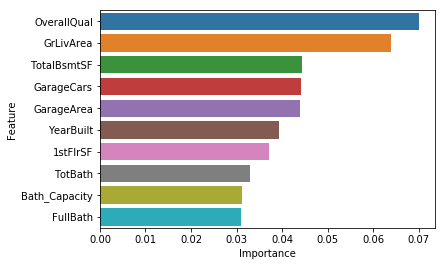

In [126]:
sns.barplot(x = 'Importance', y = 'Feature', data=result_rf1)

# Grid Search CV to Tune Random Forest

In [127]:
from sklearn.grid_search import GridSearchCV

rf_tree_cv = RandomForestRegressor(
                                bootstrap = True,
                                oob_score = True,
                                random_state = 0)

rf_param_grid = [{
        'n_estimators' : [300, 400, 500, 600], #Test[100,250,500,750,1000]
        'max_features' : np.arange(35,38), # First try: np.arange(17,40)
}]

rf_grid_search = GridSearchCV(rf_tree_cv, param_grid = rf_param_grid, cv = 5)

rf_grid_search.fit(X_train_v, y_train_v)

KeyboardInterrupt: 

## Best parameters: Max_features = 37, n_estimators = 500

In [128]:
rf_grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# Refit Random Forest with Tuned Hyperparameters

In [138]:
rf_tree = RandomForestRegressor(n_estimators = 500,
                                max_features = 37,
                                bootstrap = True,
                                oob_score = True,
                                random_state = 0)


rf_tree.fit(X_train_v, y_train_v)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=37, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

## R sq for Training: 98%, OOB: 87%, Test: 89%

Test score was <1% higher in the tuned Random Forest than the untuned Random Forest model

In [139]:
print('Training Score:', rf_tree.score(X_train_v, y_train_v))
print('OOB Score:', rf_tree.oob_score_)
print('Test Score:', rf_tree.score(X_test_v, y_test_v))

Training Score: 0.982907984916
OOB Score: 0.871618148164
Test Score: 0.894296055868


### Error: Training RMSE = .0523, Test RMSE = .1274

In [140]:
from sklearn.metrics import mean_squared_error

print('Training RMSE:' , math.sqrt(mean_squared_error(y_train_v, rf_tree.predict(X_train_v))))
print('Test RMSE:', math.sqrt(mean_squared_error(y_test_v, rf_tree.predict(X_test_v))))

Training RMSE: 0.052258663356693484
Test RMSE: 0.12744106369555977


# Score Improvement Chart (From Bagged Tree to Tuned Random Forest)

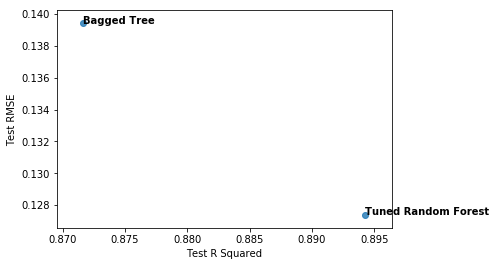

In [146]:
r = np.array([.8716, .8943])
rmse = np.array([.1394, .1274])


fig, ax = plt.subplots()
sns.regplot(x=r, y=rmse, fit_reg=False)
plt.text(.8716, .1394, "Bagged Tree", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(.8943, .1274, "Tuned Random Forest", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.set(xlabel='Test R Squared', ylabel='Test RMSE')
plt.show()

### Top 10 Important Variables

In [99]:
result = pd.concat([pd.DataFrame(X_train_v.columns.values),pd.DataFrame(rf_tree.feature_importances_)], axis = 1)
result.columns = ['Feature','Importance']
result = result.sort_values(by = 'Importance', ascending = False).head(10)

In [100]:
result

,Feature,Importance
23,OverallQual,0.121189
13,GrLivArea,0.098415
28,YearBuilt,0.059012
12,GarageCars,0.053323
26,TotalBsmtSF,0.051526
11,GarageArea,0.042570
10,FullBath,0.042418
0,1stFlrSF,0.039193
34,TotBath,0.036069
93,ExterQual_TA,0.031174


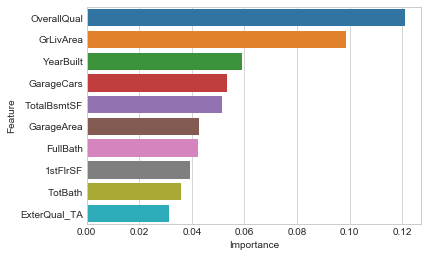

In [55]:
sns.set_style("whitegrid")
sns.barplot(x = 'Importance', y = 'Feature', data=result)

# Plotting Training and Test Error

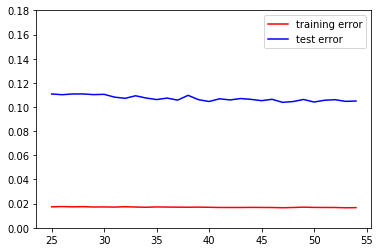

In [101]:
subset = range(25, 55)
train_error = []
test_error = []
for i in subset:
    rf_tree.set_params(max_features=i)
    rf_tree.fit(X_train_v, y_train_v)
    train_error.append(1 - rf_tree.score(X_train_v, y_train_v))
    test_error.append(1 - rf_tree.score(X_test_v, y_test_v))

import matplotlib.pyplot as plt
plt.plot(subset, train_error, c='red', label='training error')
plt.plot(subset, test_error, c='blue', label='test error')
plt.ylim(0, 0.18)
plt.legend()
plt.show()

## Thoughts so far:

The random forest models had better training and test scores as well as lower MSE than the decision tree. 

The tuned Random Forest model had slightly higher R^2 than the untuned Random Forest, BUT it also had a slightly higher 

In [60]:
R2_RForest_test = rf_tree.score(X_train_v, y_train_v)
RMSE_RForest_test = math.sqrt(mean_squared_error(y_test_v, rf_tree.predict(X_test_v)))
output_RForest_test = np.exp(rf_tree.predict(house_test_x))

# For Stacking

In [57]:
# output_RForest_test validation Rsq 
R2_RForest_test

0.98290798491596809

In [58]:
# RMSE for validation test
RMSE_RForest_test

0.12744106369555977

In [61]:
# array of predicted Ys on the real test
output_RForest_test

array([ 123263.52114917,  152166.95208687,  181439.48272637, ...,
        155008.69376957,  107883.58674749,  234182.74410917])

# Stochastic Gradient Boosting  - 1st Attempt

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

gb_tree1 = GradientBoostingRegressor(max_depth = 3, learning_rate = 0.1, subsample= 2/3, random_state=0)
gb_tree1.fit(X_train_v, y_train_v)

NameError: name 'X_train_v' is not defined

In [103]:
print('Training Score:', gb_tree1.score(X_train_v, y_train_v))
print('Test Score:', gb_tree1.score(X_test_v, y_test_v))

Training Score: 0.956408216135
Test Score: 0.91757941037


In [104]:
print('Training RMSE:', math.sqrt(mean_squared_error(y_train_v, gb_tree1.predict(X_train_v))))
print('Test RMSE:', math.sqrt(mean_squared_error(y_test_v, gb_tree1.predict(X_test_v))))

Training RMSE: 0.08345723353216222
Test RMSE: 0.11253345428318627


In [105]:
gb_result1 = pd.concat([pd.DataFrame(X_train_v.columns.values),pd.DataFrame(gb_tree1.feature_importances_)], axis = 1)
gb_result1.columns = ['Feature','Importance']
gb_result1 = result.sort_values(by = 'Importance', ascending = False).head(10)
gb_result1

,Feature,Importance
23,OverallQual,0.121189
13,GrLivArea,0.098415
28,YearBuilt,0.059012
12,GarageCars,0.053323
26,TotalBsmtSF,0.051526
11,GarageArea,0.042570
10,FullBath,0.042418
0,1stFlrSF,0.039193
34,TotBath,0.036069
93,ExterQual_TA,0.031174


# Tune Stochastic Gradient Boosting with GridSearchCV

In [160]:
gb_tree = GradientBoostingRegressor(max_depth = 3, warm_start = True)

gb_tree_cv = GradientBoostingRegressor(
                                max_depth = 3,
                                subsample = 2/3,
                                random_state = 0)

gb_param_grid = [{
        'n_estimators' : [500, 550, 600, 650], # 
        'learning_rate' : np.linspace(.02, .06, 5), # 
}]

gb_grid_search = GridSearchCV(gb_tree_cv, param_grid = gb_param_grid, cv = 5)

gb_grid_search.fit(X_train_v, y_train_v)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=0.6666666666666666, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [600, 650, 700, 800], 'learning_rate': array([ 0.02,  0.03,  0.04,  0.05,  0.06])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [154]:
np.linspace(.01, .06, 6)


array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06])

In [161]:
gb_grid_search.best_params_ # last best param: .05, 650

{'learning_rate': 0.039999999999999994, 'n_estimators': 800}

# Refit Stochastic Gradient Boost Tree with Best Hyperparameters

In [29]:
gb_tree = GradientBoostingRegressor(max_depth = 3, 
                                    learning_rate = 0.05, 
                                    n_estimators = 650,
                                    subsample= 2/3, 
                                    random_state=0)
gb_tree.fit(X_train_v, y_train_v)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=650, presort='auto', random_state=0,
             subsample=0.6666666666666666, verbose=0, warm_start=False)

### Training Score: .9871, Test Score: .9301

In [27]:
print('Training Score:', gb_tree.score(X_train_v, y_train_v))
print('Test Score:', gb_tree.score(X_test_v, y_test_v))

Training Score: 0.986841994007
Test Score: 0.928814908245


### Training RMSE: .0454, Test RMSE: .1036 ( learn = .05, n est = 650)

In [28]:
print('Training RMSE:', math.sqrt(mean_squared_error(y_train_v, gb_tree.predict(X_train_v))))
print('Test RMSE:', math.sqrt(mean_squared_error(y_test_v, gb_tree.predict(X_test_v))))

Training RMSE: 0.04585183317457261
Test RMSE: 0.10458233066164341


# Top 10 Important Variables Stochastic Gradient Boosting

In [153]:
gb_result1 = pd.concat([pd.DataFrame(X_train_v.columns.values),pd.DataFrame(gb_tree1.feature_importances_)], axis = 1)
gb_result1.columns = ['Feature','Importance']
gb_result1 = result.sort_values(by = 'Importance', ascending = False).head(10)
gb_result1

,Feature,Importance
23,OverallQual,0.121189
13,GrLivArea,0.098415
28,YearBuilt,0.059012
12,GarageCars,0.053323
26,TotalBsmtSF,0.051526
11,GarageArea,0.042570
10,FullBath,0.042418
0,1stFlrSF,0.039193
34,TotBath,0.036069
93,ExterQual_TA,0.031174


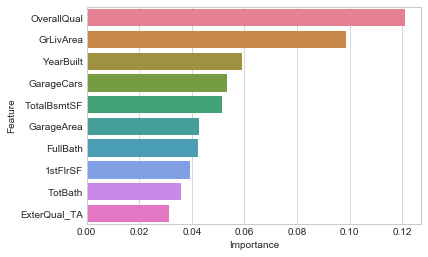

In [155]:

sns.set_style("whitegrid")
sns.barplot(x = 'Importance', y = 'Feature', data=gb_result1, palette="husl")

# For Stacking

In [168]:
R2_GBoost_test = gb_tree.score(X_train_v, y_train_v)
RMSE_GBoost_test = math.sqrt(mean_squared_error(y_test_v, gb_tree.predict(X_test_v)))
output_GBoost_test = np.exp(gb_tree.predict(house_test_x))

export predictions to csv

In [172]:
pd.DataFrame(output_GBoost_test).to_csv('My_Predictions.csv')